In [1]:
# Standard Imports
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random
import os

# Modeling Imports
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import Sequential, regularizers, Model
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import (Dense, Flatten, Input, Dropout, 
                                     Add, BatchNormalization, Activation, 
                                     Conv2D, MaxPooling2D)

from sklearn.metrics import (confusion_matrix, ConfusionMatrixDisplay, 
                             accuracy_score, precision_score)
from sklearn.utils import class_weight

# Lime Imports
%load_ext autoreload
%autoreload 2
import lime
from lime import lime_image
from skimage.segmentation import mark_boundaries

import sys
sys.path.append(os.path.join(os.pardir, os.pardir, 'src'))
import functions as fx

In [2]:
train_path = os.path.join(os.pardir, os.pardir, 'data', 'train')
test_path = os.path.join(os.pardir, os.pardir, 'data', 'test')

train_datagen = ImageDataGenerator(rescale = 1./255.,
                                   rotation_range = 30, zoom_range = 0.3,
                                   width_shift_range = 0.2, height_shift_range = 0.2,
                                   horizontal_flip = True, brightness_range = [0.5, 1.5], 
                                   validation_split = 0.1)
val_datagen = ImageDataGenerator(rescale = 1./255, validation_split = 0.1)
train_generator = train_datagen.flow_from_directory(
    train_path, seed = 55, target_size = (256, 256), 
    batch_size = 64, class_mode = 'binary', 
    classes = ['perennials', 'weeds'], subset = 'training')
val_generator = val_datagen.flow_from_directory(
    train_path, seed = 55, target_size = (256, 256),
    batch_size = 64, class_mode = 'binary', 
    classes = ['perennials', 'weeds'], subset = 'validation')
test_generator = ImageDataGenerator(rescale = 1./255.) \
    .flow_from_directory(test_path, target_size = (256, 256), 
                         batch_size = 64, class_mode = 'binary', 
                         classes = ['perennials', 'weeds'])

Found 4698 images belonging to 2 classes.
Found 521 images belonging to 2 classes.
Found 580 images belonging to 2 classes.


In [15]:
# Calculate weights to balance perennial and weed data in training set
class_weights = class_weight.compute_class_weight(
    class_weight = 'balanced', classes = np.unique(train_generator.classes), 
    y = train_generator.classes)
train_class_weights = dict(enumerate(class_weights))

# Stop training if validation accuracy does not decrease in 15 epochs
early_stop_loss = EarlyStopping(monitor = 'val_accuracy', patience = 15, restore_best_weights = True)

In [4]:
def trial_1(image):
    layers = [
        Input(image.shape),
        Conv2D(16, (5, 5), activation = 'relu'),
        MaxPooling2D((2, 2)),
        BatchNormalization(),
        Conv2D(32, (5, 5), activation = 'relu'),
        MaxPooling2D((2, 2)),
        BatchNormalization(),
        Conv2D(64, (5, 5), activation = 'relu'),
        MaxPooling2D((2, 2)),
        BatchNormalization(),
        Flatten(),
        Dense(512, activation = 'relu'),
        Dense(256, activation = 'relu'),
        Dense(128, activation = 'relu'),
        Dense(64, activation = 'relu'),
        Dense(1, activation = 'sigmoid')
    ]
    model = Sequential(layers)
    model.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics=['accuracy', 'Precision'])
    return model

In [5]:
model_1 = trial_1(train_generator[0][0][0])
model_1.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 252, 252, 16)      1216      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 126, 126, 16)      0         
_________________________________________________________________
batch_normalization (BatchNo (None, 126, 126, 16)      64        
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 122, 122, 32)      12832     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 61, 61, 32)        0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 61, 61, 32)        128       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 57, 57, 64)        5

In [6]:
result_1 = model_1.fit(train_generator, epochs = 75, validation_data=val_generator,
                       class_weight = train_class_weights, callbacks = [early_stop_loss])

Epoch 1/75
74/74 [==============================] - 124s 2s/step - loss: 1.2381 - accuracy: 0.6420 - precision: 0.6543 - val_loss: 1.1004 - val_accuracy: 0.5106 - val_precision: 0.5126
Epoch 2/75
74/74 [==============================] - 124s 2s/step - loss: 0.6766 - accuracy: 0.6911 - precision: 0.6988 - val_loss: 0.8175 - val_accuracy: 0.5144 - val_precision: 0.5144
Epoch 3/75
74/74 [==============================] - 124s 2s/step - loss: 0.5961 - accuracy: 0.7158 - precision: 0.7249 - val_loss: 0.7042 - val_accuracy: 0.5854 - val_precision: 0.5586
Epoch 4/75
74/74 [==============================] - 124s 2s/step - loss: 0.5364 - accuracy: 0.7450 - precision: 0.7408 - val_loss: 0.7357 - val_accuracy: 0.5566 - val_precision: 0.5394
Epoch 5/75
74/74 [==============================] - 124s 2s/step - loss: 0.5067 - accuracy: 0.7527 - precision: 0.7552 - val_loss: 0.9101 - val_accuracy: 0.5950 - val_precision: 0.5616
Epoch 6/75
74/74 [==============================] - 125s 2s/step - loss: 0.

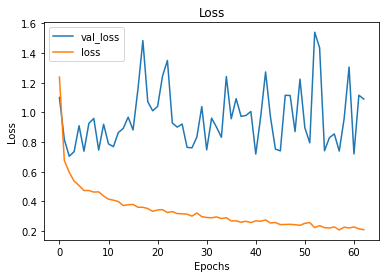

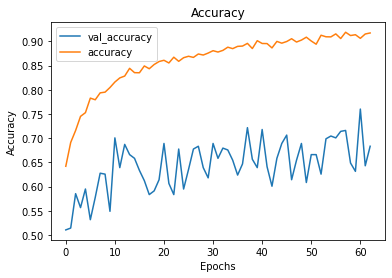

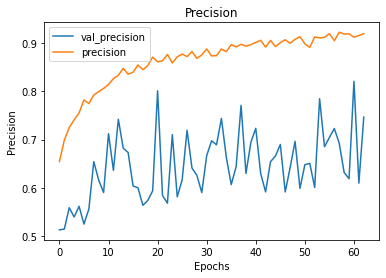

In [7]:
fx.visualize_training_results(result_1)

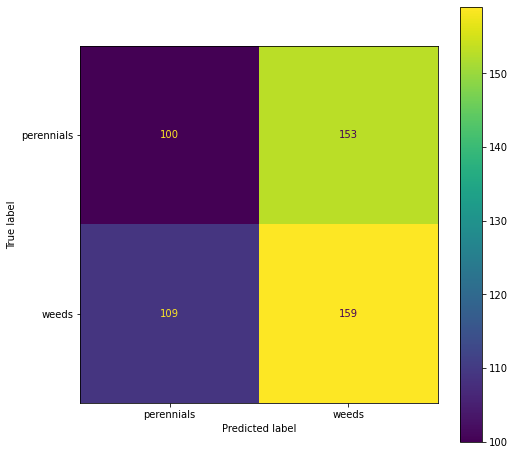

In [8]:
fx.create_confusion_matrix(model_1, val_generator)

In [9]:
fx.get_metrics(model_1, val_generator)

Accuracy: 0.4971209213051823
Precision: 0.5096153846153846


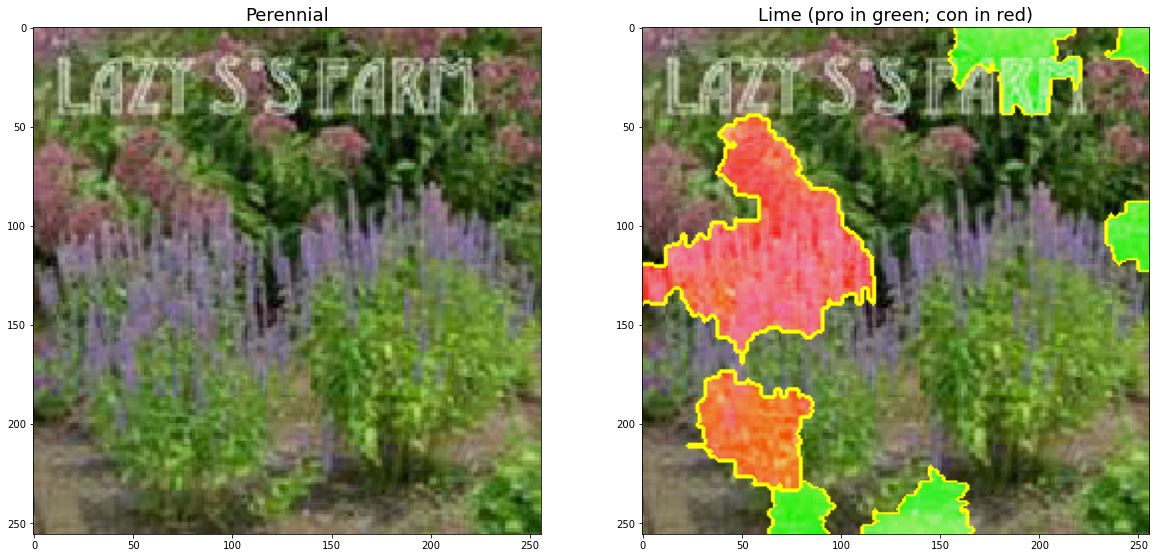

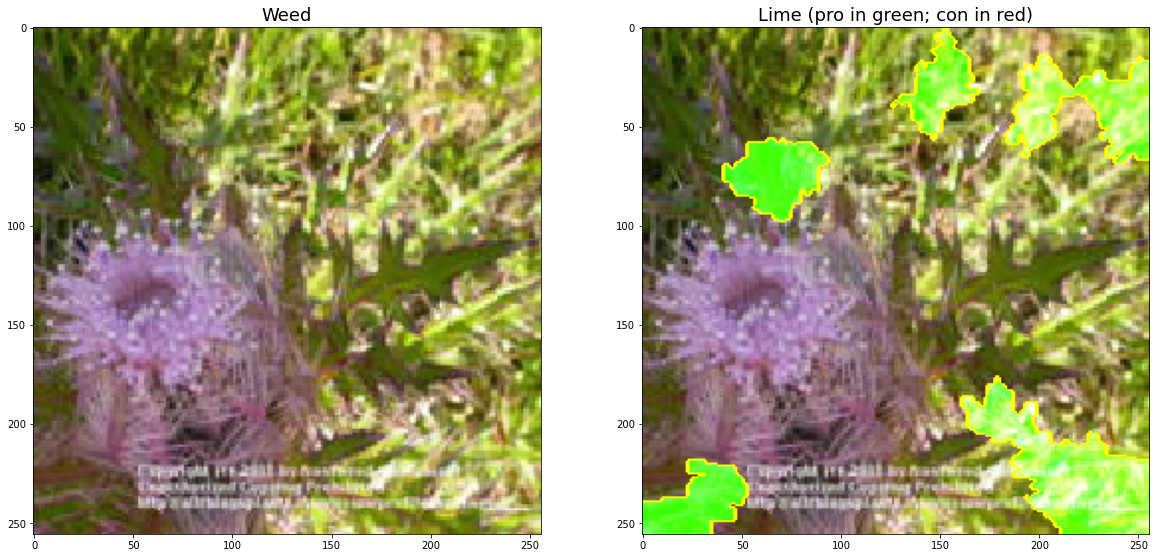

In [10]:
fx.display_lime(model_1, val_generator)

In [14]:
result_1 = model_1.fit(train_generator, epochs = 50, validation_data=val_generator,
                       class_weight = train_class_weights, callbacks = [early_stop_loss])

Epoch 1/50
74/74 [==============================] - 136s 2s/step - loss: 0.2183 - accuracy: 0.9168 - precision: 0.9236 - val_loss: 0.9527 - val_accuracy: 0.6737 - val_precision: 0.6458
Epoch 2/50
74/74 [==============================] - 129s 2s/step - loss: 0.2025 - accuracy: 0.9227 - precision: 0.9235 - val_loss: 1.3062 - val_accuracy: 0.6737 - val_precision: 0.6856
Epoch 3/50
74/74 [==============================] - 128s 2s/step - loss: 0.2152 - accuracy: 0.9112 - precision: 0.9123 - val_loss: 1.0336 - val_accuracy: 0.6833 - val_precision: 0.6820
Epoch 4/50
74/74 [==============================] - 138s 2s/step - loss: 0.1966 - accuracy: 0.9159 - precision: 0.9169 - val_loss: 1.1815 - val_accuracy: 0.6967 - val_precision: 0.7477
Epoch 5/50
74/74 [==============================] - 129s 2s/step - loss: 0.2239 - accuracy: 0.9161 - precision: 0.9186 - val_loss: 2.7567 - val_accuracy: 0.5720 - val_precision: 0.5610
Epoch 6/50
74/74 [==============================] - 130s 2s/step - loss: 0.

In [22]:
result_1 = model_1.fit(train_generator, epochs = 50, validation_data=val_generator,
                       class_weight = train_class_weights, callbacks = [early_stop_loss])

Epoch 1/50
74/74 [==============================] - 128s 2s/step - loss: 0.2234 - accuracy: 0.9134 - precision: 0.9117 - val_loss: 0.9057 - val_accuracy: 0.6948 - val_precision: 0.6510
Epoch 2/50
74/74 [==============================] - 128s 2s/step - loss: 0.2121 - accuracy: 0.9172 - precision: 0.9219 - val_loss: 1.1489 - val_accuracy: 0.6660 - val_precision: 0.6679
Epoch 3/50
74/74 [==============================] - 128s 2s/step - loss: 0.2091 - accuracy: 0.9155 - precision: 0.9131 - val_loss: 1.0439 - val_accuracy: 0.6603 - val_precision: 0.6296
Epoch 4/50
74/74 [==============================] - 128s 2s/step - loss: 0.2070 - accuracy: 0.9155 - precision: 0.9151 - val_loss: 1.4400 - val_accuracy: 0.6526 - val_precision: 0.6239
Epoch 5/50
74/74 [==============================] - 128s 2s/step - loss: 0.2087 - accuracy: 0.9151 - precision: 0.9150 - val_loss: 0.8459 - val_accuracy: 0.6795 - val_precision: 0.6772
Epoch 6/50
74/74 [==============================] - 128s 2s/step - loss: 0.

In [16]:
def trial_2(image):
    layers = [
        Input(image.shape),
        Conv2D(16, (5, 5), activation = 'relu'),
        MaxPooling2D((2, 2)),
        BatchNormalization(),
        Conv2D(32, (5, 5), activation = 'relu'),
        MaxPooling2D((2, 2)),
        BatchNormalization(),
        Conv2D(64, (5, 5), activation = 'relu'),
        MaxPooling2D((2, 2)),
        BatchNormalization(),
        Flatten(),
        Dense(512, activation = 'relu'),
        Dropout(0.2),
        Dense(256, activation = 'relu'),
        Dense(128, activation = 'relu'),
        Dense(64, activation = 'relu'),
        Dense(1, activation = 'sigmoid')
    ]
    model = Sequential(layers)
    model.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics=['accuracy', 'Precision'])
    return model

In [17]:
model_2 = trial_2(train_generator[0][0][0])
model_2.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 252, 252, 16)      1216      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 126, 126, 16)      0         
_________________________________________________________________
batch_normalization_3 (Batch (None, 126, 126, 16)      64        
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 122, 122, 32)      12832     
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 61, 61, 32)        0         
_________________________________________________________________
batch_normalization_4 (Batch (None, 61, 61, 32)        128       
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 57, 57, 64)       

In [18]:
result_2 = model_2.fit(train_generator, epochs = 75, validation_data=val_generator,
                       class_weight = train_class_weights, callbacks = [early_stop_loss])

Epoch 1/75
74/74 [==============================] - 129s 2s/step - loss: 1.1796 - accuracy: 0.6362 - precision: 0.6457 - val_loss: 1.4366 - val_accuracy: 0.5106 - val_precision: 0.5125
Epoch 2/75
74/74 [==============================] - 128s 2s/step - loss: 0.7300 - accuracy: 0.6786 - precision: 0.6787 - val_loss: 0.7221 - val_accuracy: 0.5278 - val_precision: 0.5965
Epoch 3/75
74/74 [==============================] - 128s 2s/step - loss: 0.6342 - accuracy: 0.7035 - precision: 0.7061 - val_loss: 1.1033 - val_accuracy: 0.5144 - val_precision: 0.5144
Epoch 4/75
74/74 [==============================] - 128s 2s/step - loss: 0.5583 - accuracy: 0.7395 - precision: 0.7357 - val_loss: 0.7461 - val_accuracy: 0.5432 - val_precision: 0.5305
Epoch 5/75
74/74 [==============================] - 128s 2s/step - loss: 0.5422 - accuracy: 0.7476 - precision: 0.7446 - val_loss: 0.6675 - val_accuracy: 0.6123 - val_precision: 0.7012
Epoch 6/75
74/74 [==============================] - 128s 2s/step - loss: 0.

In [23]:
result_2 = model_2.fit(train_generator, epochs = 50, validation_data=val_generator,
                       class_weight = train_class_weights, callbacks = [early_stop_loss])

Epoch 1/50
74/74 [==============================] - 129s 2s/step - loss: 0.2000 - accuracy: 0.9251 - precision: 0.9200 - val_loss: 0.6287 - val_accuracy: 0.7793 - val_precision: 0.7647
Epoch 2/50
74/74 [==============================] - 131s 2s/step - loss: 0.1988 - accuracy: 0.9244 - precision: 0.9276 - val_loss: 0.7514 - val_accuracy: 0.7140 - val_precision: 0.6766
Epoch 3/50
74/74 [==============================] - 130s 2s/step - loss: 0.1929 - accuracy: 0.9234 - precision: 0.9239 - val_loss: 0.8594 - val_accuracy: 0.7121 - val_precision: 0.7341
Epoch 4/50
74/74 [==============================] - 130s 2s/step - loss: 0.1932 - accuracy: 0.9261 - precision: 0.9229 - val_loss: 1.4797 - val_accuracy: 0.6104 - val_precision: 0.7826
Epoch 5/50
74/74 [==============================] - 130s 2s/step - loss: 0.1884 - accuracy: 0.9281 - precision: 0.9222 - val_loss: 0.6886 - val_accuracy: 0.7447 - val_precision: 0.7509
Epoch 6/50
74/74 [==============================] - 130s 2s/step - loss: 0.

In [19]:
def trial_3(image):
    layers = [
        Input(image.shape),
        Conv2D(16, (5, 5), activation = 'relu'),
        MaxPooling2D((2, 2)),
        BatchNormalization(),
        Conv2D(32, (5, 5), activation = 'relu'),
        MaxPooling2D((2, 2)),
        BatchNormalization(),
        Conv2D(64, (5, 5), activation = 'relu'),
        MaxPooling2D((2, 2)),
        BatchNormalization(),
        Flatten(),
        Dense(512, activation = 'relu', kernel_regularizer = regularizers.l2(0.01)),
        Dense(256, activation = 'relu'),
        Dense(128, activation = 'relu'),
        Dense(64, activation = 'relu'),
        Dense(1, activation = 'sigmoid')
    ]
    model = Sequential(layers)
    model.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics=['accuracy', 'Precision'])
    return model

In [20]:
model_3 = trial_3(train_generator[0][0][0])
model_3.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 252, 252, 16)      1216      
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 126, 126, 16)      0         
_________________________________________________________________
batch_normalization_6 (Batch (None, 126, 126, 16)      64        
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 122, 122, 32)      12832     
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 61, 61, 32)        0         
_________________________________________________________________
batch_normalization_7 (Batch (None, 61, 61, 32)        128       
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 57, 57, 64)       

In [21]:
result_3 = model_3.fit(train_generator, epochs = 75, validation_data=val_generator,
                       class_weight = train_class_weights, callbacks = [early_stop_loss])

Epoch 1/75
74/74 [==============================] - 132s 2s/step - loss: 7.7335 - accuracy: 0.6409 - precision: 0.6494 - val_loss: 2.2951 - val_accuracy: 0.5182 - val_precision: 0.5166
Epoch 2/75
74/74 [==============================] - 132s 2s/step - loss: 1.2851 - accuracy: 0.7135 - precision: 0.7125 - val_loss: 1.2069 - val_accuracy: 0.5106 - val_precision: 0.5126
Epoch 3/75
74/74 [==============================] - 133s 2s/step - loss: 1.0595 - accuracy: 0.7271 - precision: 0.7290 - val_loss: 1.2484 - val_accuracy: 0.5125 - val_precision: 0.5136
Epoch 4/75
74/74 [==============================] - 132s 2s/step - loss: 0.8906 - accuracy: 0.7488 - precision: 0.7400 - val_loss: 1.0476 - val_accuracy: 0.5393 - val_precision: 0.5299
Epoch 5/75
74/74 [==============================] - 132s 2s/step - loss: 0.8510 - accuracy: 0.7584 - precision: 0.7502 - val_loss: 1.1766 - val_accuracy: 0.5509 - val_precision: 0.5351
Epoch 6/75
74/74 [==============================] - 132s 2s/step - loss: 0.

In [24]:
result_3 = model_3.fit(train_generator, epochs = 50, validation_data=val_generator,
                       class_weight = train_class_weights, callbacks = [early_stop_loss])

Epoch 1/50
74/74 [==============================] - 129s 2s/step - loss: 0.7239 - accuracy: 0.8872 - precision: 0.8971 - val_loss: 1.1798 - val_accuracy: 0.7159 - val_precision: 0.7500
Epoch 2/50
74/74 [==============================] - 129s 2s/step - loss: 0.7783 - accuracy: 0.8806 - precision: 0.8921 - val_loss: 1.5103 - val_accuracy: 0.6411 - val_precision: 0.6319
Epoch 3/50
74/74 [==============================] - 129s 2s/step - loss: 0.7397 - accuracy: 0.8887 - precision: 0.8964 - val_loss: 1.2290 - val_accuracy: 0.7140 - val_precision: 0.8020
Epoch 4/50
74/74 [==============================] - 130s 2s/step - loss: 0.7806 - accuracy: 0.8778 - precision: 0.8905 - val_loss: 1.4184 - val_accuracy: 0.6948 - val_precision: 0.7739
Epoch 5/50
74/74 [==============================] - 129s 2s/step - loss: 0.7579 - accuracy: 0.8844 - precision: 0.8972 - val_loss: 1.2420 - val_accuracy: 0.7063 - val_precision: 0.7447
Epoch 6/50
74/74 [==============================] - 130s 2s/step - loss: 0.